In [1]:
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm

from util import *
from model.pinn import PINNs
from model.pinnsformer import PINNsformer

In [2]:
#设置种子和设备
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:1'

In [3]:
# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([-1,1], [0,1], 128, 100) #获取训练数据，第一个参数是x的取值范围，第二个参数是t的取值范围，第三个和第四个参数分别是x和t的采样点数
#这样，res是一个形状为(51*51,2)的数组，其中每一行代表一个(x,t)点的坐标，代表配位点/训练数据。b_left、b_right、b_upper和b_lower分别是边界条件的训练点，这些点用于训练PINNsformer模型。
res_test, _, _, _, _ = get_data([-1,1], [0,1], 256, 100) #生成测试数据，采样点数为101x101
#这样，res_test是一个形状为(101*101,2)的数组，代表测试数据

#将数据转换为时间序列，输入的数据形状为(N, 2)，第一列x第二列t。最后返回的是一个伪时间序列数据，形状为(N, num_step, 2)，step则代表Δt，是伪时间序列的递增量。相当于把N个[x,t]转换为{[x,t],[x,t+Δt],[x,t+2Δt],...,[x,t+(num_step-1)Δt]}，即每个空间位置都有一个时间序列。
res = make_time_sequence(res, num_step=5, step=1e-4) #配位点的时间序列数据，res形状变为(51*51, 5, 2)，即每个(x,t)点都有5个时间步的序列数据
b_left = make_time_sequence(b_left, num_step=5, step=1e-4) #左边界条件的时间序列数据，b_left形状变为(51, 5, 2)
b_right = make_time_sequence(b_right, num_step=5, step=1e-4) #右边界条件的时间序列数据，b_right形状变为(51, 5, 2)
b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4) #上边界条件的时间序列数据，b_upper形状变为(51, 5, 2)
b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4) #下边界条件的时间序列数据，b_lower形状变为(51, 5, 2)

#将数据转移到显卡上
res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

#将数据分离为x和t的部分
x_res, t_res = res[:,:,0:1], res[:,:,1:2] #将res的第一列作为x，第二列作为t,这样x_res和t_res的形状都是(51*51, 5, 1)，即51*51个时间序列，每个(x,t)点都有5个时间步的序列数据
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2] #将b_left的第一列作为x，第二列作为t,这样x_left和t_left的形状都是(51, 5, 1)，即每个左边界点都有5个时间步的序列数据
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2] #将b_right的第一列作为x，第二列作为t,这样x_right和t_right的形状都是(51, 5, 1)，即每个右边界点都有5个时间步的序列数据
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2] #将b_upper的第一列作为x，第二列作为t,这样x_upper和t_upper的形状都是(51, 5, 1)，即每个上边界点都有5个时间步的序列数据
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2] #将b_lower的第一列作为x，第二列作为t,这样x_lower和t_lower的形状都是(51, 5, 1)，即每个下边界点都有5个时间步的序列数据

#初始化神经网络的线性层权重参数，使用Xavier初始化权重，偏置则初始化为0.01
def init_weights(m):
    if isinstance(m, nn.Linear): #判断是否是线性层
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [4]:
model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device) #创建PINNsformer模型，模型输出维度为1，outputlayer模块的隐藏层维度为512，数据的特征嵌入维度为32，编码器和解码器的层数为1，注意力机制的头数为2

model.apply(init_weights) #初始化模型中线性层的权重和偏置
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe') #使用LBFGS优化器，line_search_fn='strong_wolfe'表示使用强Wolfe线搜索方法

print(model) #打印模型结构
print(get_n_params(model)) #打印模型参数数量

/tmp/ipykernel_1342141/2548638020.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


PINNsformer(
  (linear_emb): Linear(in_features=2, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequen

In [5]:
loss_track = [] #记录loss

for i in tqdm(range(500)): #训练500次
    def closure():
        pred_res = model(x_res, t_res) #得到配位点的预测结果
        pred_left = model(x_left, t_left) #得到左边界点的预测结果
        pred_right = model(x_right, t_right) #得到右边界点的预测结果
        pred_upper = model(x_upper, t_upper) #得到上边界点的预测结果
        pred_lower = model(x_lower, t_lower) #得到下边界点的预测结果

        #计算配位点的时间导数u_t和空间导数u_x
        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]

        pred_x_upper = torch.autograd.grad(pred_upper, x_upper, grad_outputs=torch.ones_like(pred_upper), retain_graph=True, create_graph=True)[0]
        pred_x_lower = torch.autograd.grad(pred_lower, x_lower, grad_outputs=torch.ones_like(pred_lower), retain_graph=True, create_graph=True)[0]

        #计算损失，共三项损失
        loss_res = torch.mean((u_t + pred_res * u_x - 0.01/torch.pi * u_xx) ** 2)
        # loss_res = torch.mean((u_t - 5 * pred_res * (1-pred_res)) ** 2)
        # loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower)**2)
        # loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)
        loss_ic = torch.mean((pred_left[:,0] + torch.sin(torch.pi*x_left[:,0])) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:05<47:37,  5.73s/it]

  0%|          | 2/500 [00:12<51:15,  6.18s/it]

  1%|          | 3/500 [00:18<53:26,  6.45s/it]

  1%|          | 4/500 [00:25<53:31,  6.48s/it]

  1%|          | 5/500 [00:31<51:57,  6.30s/it]

  1%|          | 6/500 [00:38<52:32,  6.38s/it]

  1%|▏         | 7/500 [00:43<50:43,  6.17s/it]

  2%|▏         | 8/500 [00:50<51:35,  6.29s/it]

  2%|▏         | 9/500 [00:57<52:49,  6.46s/it]

  2%|▏         | 10/500 [01:03<52:57,  6.48s/it]

  2%|▏         | 11/500 [01:09<52:19,  6.42s/it]

  2%|▏         | 12/500 [01:15<50:33,  6.22s/it]

  3%|▎         | 13/500 [01:21<49:19,  6.08s/it]

  3%|▎         | 14/500 [01:27<49:04,  6.06s/it]

  3%|▎         | 15/500 [01:33<48:12,  5.96s/it]

  3%|▎         | 16/500 [01:39<48:53,  6.06s/it]

  3%|▎         | 17/500 [01:46<49:59,  6.21s/it]

  4%|▎         | 18/500 [01:52<50:04,  6.23s/it]

  4%|▍         | 19/500 [01:58<49:27,  6.17s/it]

  4%|▍         | 20/500 [02:04<48:19,  6.04s/it]

  4%|▍         | 21/500 [02:10<48:09,  6.03s/it]

  4%|▍         | 22/500 [02:16<48:01,  6.03s/it]

  5%|▍         | 23/500 [02:21<47:15,  5.94s/it]

  5%|▍         | 24/500 [02:27<47:18,  5.96s/it]

  5%|▌         | 25/500 [02:33<46:42,  5.90s/it]

  5%|▌         | 26/500 [02:39<46:54,  5.94s/it]

  5%|▌         | 27/500 [02:45<46:23,  5.88s/it]

  6%|▌         | 28/500 [02:51<45:57,  5.84s/it]

  6%|▌         | 29/500 [02:56<45:41,  5.82s/it]

  6%|▌         | 30/500 [03:02<45:25,  5.80s/it]

  6%|▌         | 31/500 [03:08<46:28,  5.95s/it]

  6%|▋         | 32/500 [03:15<47:10,  6.05s/it]

  7%|▋         | 33/500 [03:21<46:21,  5.96s/it]

  7%|▋         | 34/500 [03:27<47:39,  6.14s/it]

  7%|▋         | 35/500 [03:33<46:39,  6.02s/it]

  7%|▋         | 36/500 [03:39<45:56,  5.94s/it]

  7%|▋         | 37/500 [03:44<45:24,  5.88s/it]

  8%|▊         | 38/500 [03:50<44:59,  5.84s/it]

  8%|▊         | 39/500 [03:56<44:41,  5.82s/it]

  8%|▊         | 40/500 [04:02<44:25,  5.79s/it]

  8%|▊         | 41/500 [04:07<44:12,  5.78s/it]

  8%|▊         | 42/500 [04:13<44:04,  5.77s/it]

  9%|▊         | 43/500 [04:19<43:54,  5.76s/it]

  9%|▉         | 44/500 [04:25<43:47,  5.76s/it]

  9%|▉         | 45/500 [04:30<43:41,  5.76s/it]

  9%|▉         | 46/500 [04:36<43:35,  5.76s/it]

  9%|▉         | 47/500 [04:42<43:29,  5.76s/it]

 10%|▉         | 48/500 [04:48<43:22,  5.76s/it]

 10%|▉         | 49/500 [04:53<43:14,  5.75s/it]

 10%|█         | 50/500 [04:59<43:08,  5.75s/it]

 10%|█         | 51/500 [05:05<44:14,  5.91s/it]

 10%|█         | 52/500 [05:11<44:21,  5.94s/it]

 11%|█         | 53/500 [05:17<44:28,  5.97s/it]

 11%|█         | 54/500 [05:23<44:28,  5.98s/it]

 11%|█         | 55/500 [05:30<45:04,  6.08s/it]

 11%|█         | 56/500 [05:36<44:16,  5.98s/it]

 11%|█▏        | 57/500 [05:42<44:18,  6.00s/it]

 12%|█▏        | 58/500 [05:47<43:39,  5.93s/it]

 12%|█▏        | 59/500 [05:53<43:10,  5.87s/it]

 12%|█▏        | 60/500 [05:59<42:48,  5.84s/it]

 12%|█▏        | 61/500 [06:05<43:41,  5.97s/it]

 12%|█▏        | 62/500 [06:11<43:07,  5.91s/it]

 13%|█▎        | 63/500 [06:17<43:16,  5.94s/it]

 13%|█▎        | 64/500 [06:23<43:58,  6.05s/it]

 13%|█▎        | 65/500 [06:30<45:33,  6.28s/it]

 13%|█▎        | 66/500 [06:37<46:39,  6.45s/it]

 13%|█▎        | 67/500 [06:43<46:12,  6.40s/it]

 14%|█▎        | 68/500 [06:50<47:01,  6.53s/it]

 14%|█▍        | 69/500 [06:56<46:23,  6.46s/it]

 14%|█▍        | 70/500 [07:03<45:56,  6.41s/it]

 14%|█▍        | 71/500 [07:09<44:58,  6.29s/it]

 14%|█▍        | 72/500 [07:15<46:04,  6.46s/it]

 15%|█▍        | 73/500 [07:22<46:45,  6.57s/it]

 15%|█▍        | 74/500 [07:29<47:10,  6.64s/it]

 15%|█▌        | 75/500 [07:35<46:17,  6.54s/it]

 15%|█▌        | 76/500 [07:42<46:18,  6.55s/it]

 15%|█▌        | 77/500 [07:49<46:45,  6.63s/it]

 16%|█▌        | 78/500 [07:55<45:20,  6.45s/it]

 16%|█▌        | 79/500 [08:02<46:35,  6.64s/it]

 16%|█▌        | 80/500 [08:08<44:35,  6.37s/it]

 16%|█▌        | 81/500 [08:13<43:09,  6.18s/it]

 16%|█▋        | 82/500 [08:20<43:18,  6.22s/it]

 17%|█▋        | 83/500 [08:26<44:30,  6.40s/it]

 17%|█▋        | 84/500 [08:33<44:08,  6.37s/it]

 17%|█▋        | 85/500 [08:40<45:01,  6.51s/it]

 17%|█▋        | 86/500 [08:46<45:36,  6.61s/it]

 17%|█▋        | 87/500 [08:52<44:17,  6.44s/it]

 18%|█▊        | 88/500 [08:59<44:28,  6.48s/it]

 18%|█▊        | 89/500 [09:05<43:25,  6.34s/it]

 18%|█▊        | 90/500 [09:11<43:11,  6.32s/it]

 18%|█▊        | 91/500 [09:17<42:28,  6.23s/it]

 18%|█▊        | 92/500 [09:23<41:24,  6.09s/it]

 19%|█▊        | 93/500 [09:30<42:47,  6.31s/it]

 19%|█▉        | 94/500 [09:37<43:13,  6.39s/it]

 19%|█▉        | 95/500 [09:43<42:56,  6.36s/it]

 19%|█▉        | 96/500 [09:49<43:18,  6.43s/it]

 19%|█▉        | 97/500 [09:56<43:28,  6.47s/it]

 20%|█▉        | 98/500 [10:03<44:05,  6.58s/it]

 20%|█▉        | 99/500 [10:10<44:30,  6.66s/it]

 20%|██        | 100/500 [10:17<44:44,  6.71s/it]

 20%|██        | 101/500 [10:23<43:48,  6.59s/it]

 20%|██        | 102/500 [10:29<43:39,  6.58s/it]

 21%|██        | 103/500 [10:35<42:26,  6.42s/it]

 21%|██        | 104/500 [10:41<41:35,  6.30s/it]

 21%|██        | 105/500 [10:48<42:32,  6.46s/it]

 21%|██        | 106/500 [10:55<43:09,  6.57s/it]

 21%|██▏       | 107/500 [11:02<43:34,  6.65s/it]

 22%|██▏       | 108/500 [11:08<42:44,  6.54s/it]

 22%|██▏       | 109/500 [11:14<41:37,  6.39s/it]

 22%|██▏       | 110/500 [11:20<40:49,  6.28s/it]

 22%|██▏       | 111/500 [11:26<40:11,  6.20s/it]

 22%|██▏       | 112/500 [11:33<41:19,  6.39s/it]

 23%|██▎       | 113/500 [11:39<39:58,  6.20s/it]

 23%|██▎       | 114/500 [11:45<39:32,  6.15s/it]

 23%|██▎       | 115/500 [11:52<40:48,  6.36s/it]

 23%|██▎       | 116/500 [11:58<41:07,  6.43s/it]

 23%|██▎       | 117/500 [12:05<40:47,  6.39s/it]

 24%|██▎       | 118/500 [12:11<41:29,  6.52s/it]

 24%|██▍       | 119/500 [12:18<42:00,  6.62s/it]

 24%|██▍       | 120/500 [12:25<41:46,  6.60s/it]

 24%|██▍       | 121/500 [12:31<41:38,  6.59s/it]

 24%|██▍       | 122/500 [12:37<40:26,  6.42s/it]

 25%|██▍       | 123/500 [12:44<40:05,  6.38s/it]

 25%|██▍       | 124/500 [12:50<39:48,  6.35s/it]

 25%|██▌       | 125/500 [12:56<39:37,  6.34s/it]

 25%|██▌       | 126/500 [13:03<39:24,  6.32s/it]

 25%|██▌       | 127/500 [13:09<39:45,  6.40s/it]

 26%|██▌       | 128/500 [13:15<39:26,  6.36s/it]

 26%|██▌       | 129/500 [13:22<38:42,  6.26s/it]

 26%|██▌       | 130/500 [13:28<39:40,  6.43s/it]

 26%|██▌       | 131/500 [13:35<39:17,  6.39s/it]

 26%|██▋       | 132/500 [13:41<39:58,  6.52s/it]

 27%|██▋       | 133/500 [13:48<40:00,  6.54s/it]

 27%|██▋       | 134/500 [13:55<39:57,  6.55s/it]

 27%|██▋       | 135/500 [14:01<39:22,  6.47s/it]

 27%|██▋       | 136/500 [14:08<39:55,  6.58s/it]

 27%|██▋       | 137/500 [14:14<39:19,  6.50s/it]

 28%|██▊       | 138/500 [14:21<39:50,  6.60s/it]

 28%|██▊       | 139/500 [14:27<39:38,  6.59s/it]

 28%|██▊       | 140/500 [14:34<39:29,  6.58s/it]

 28%|██▊       | 141/500 [14:41<39:51,  6.66s/it]

 28%|██▊       | 142/500 [14:48<40:03,  6.71s/it]

 29%|██▊       | 143/500 [14:55<40:07,  6.74s/it]

 29%|██▉       | 144/500 [15:01<39:11,  6.60s/it]

 29%|██▉       | 145/500 [15:07<38:02,  6.43s/it]

 29%|██▉       | 146/500 [15:13<38:10,  6.47s/it]

 29%|██▉       | 147/500 [15:20<38:44,  6.58s/it]

 30%|██▉       | 148/500 [15:26<37:40,  6.42s/it]

 30%|██▉       | 149/500 [15:33<37:48,  6.46s/it]

 30%|███       | 150/500 [15:39<37:53,  6.50s/it]

 30%|███       | 151/500 [15:46<38:22,  6.60s/it]

 30%|███       | 152/500 [15:53<37:44,  6.51s/it]

 31%|███       | 153/500 [15:59<38:09,  6.60s/it]

 31%|███       | 154/500 [16:06<38:25,  6.66s/it]

 31%|███       | 155/500 [16:12<37:10,  6.47s/it]

 31%|███       | 156/500 [16:19<37:12,  6.49s/it]

 31%|███▏      | 157/500 [16:26<37:37,  6.58s/it]

 32%|███▏      | 158/500 [16:32<37:26,  6.57s/it]

 32%|███▏      | 159/500 [16:39<37:17,  6.56s/it]

 32%|███▏      | 160/500 [16:45<37:36,  6.64s/it]

 32%|███▏      | 161/500 [16:52<38:14,  6.77s/it]

 32%|███▏      | 162/500 [16:59<37:44,  6.70s/it]

 33%|███▎      | 163/500 [17:06<37:22,  6.65s/it]

 33%|███▎      | 164/500 [17:12<36:10,  6.46s/it]

 33%|███▎      | 165/500 [17:18<35:45,  6.40s/it]

 33%|███▎      | 166/500 [17:25<36:19,  6.53s/it]

 33%|███▎      | 167/500 [17:31<36:14,  6.53s/it]

 34%|███▎      | 168/500 [17:38<36:37,  6.62s/it]

 34%|███▍      | 169/500 [17:44<35:56,  6.51s/it]

 34%|███▍      | 170/500 [17:51<36:18,  6.60s/it]

 34%|███▍      | 171/500 [17:58<36:59,  6.75s/it]

 34%|███▍      | 172/500 [18:05<36:59,  6.77s/it]

 35%|███▍      | 173/500 [18:11<35:37,  6.54s/it]

 35%|███▍      | 174/500 [18:18<35:58,  6.62s/it]

 35%|███▌      | 175/500 [18:24<34:51,  6.44s/it]

 35%|███▌      | 176/500 [18:31<35:21,  6.55s/it]

 35%|███▌      | 177/500 [18:37<34:48,  6.47s/it]

 36%|███▌      | 178/500 [18:43<34:23,  6.41s/it]

 36%|███▌      | 179/500 [18:50<34:55,  6.53s/it]

 36%|███▌      | 180/500 [18:57<35:15,  6.61s/it]

 36%|███▌      | 181/500 [19:03<34:36,  6.51s/it]

 36%|███▋      | 182/500 [19:10<34:58,  6.60s/it]

 37%|███▋      | 183/500 [19:16<33:59,  6.43s/it]

 37%|███▋      | 184/500 [19:22<34:03,  6.47s/it]

 37%|███▋      | 185/500 [19:29<33:38,  6.41s/it]

 37%|███▋      | 186/500 [19:35<33:45,  6.45s/it]

 37%|███▋      | 187/500 [19:42<33:22,  6.40s/it]

 38%|███▊      | 188/500 [19:48<33:29,  6.44s/it]

 38%|███▊      | 189/500 [19:55<33:57,  6.55s/it]

 38%|███▊      | 190/500 [20:01<33:50,  6.55s/it]

 38%|███▊      | 191/500 [20:08<33:43,  6.55s/it]

 38%|███▊      | 192/500 [20:15<34:01,  6.63s/it]

 39%|███▊      | 193/500 [20:22<34:16,  6.70s/it]

 39%|███▉      | 194/500 [20:28<33:08,  6.50s/it]

 39%|███▉      | 195/500 [20:34<33:06,  6.51s/it]

 39%|███▉      | 196/500 [20:41<33:27,  6.60s/it]

 39%|███▉      | 197/500 [20:47<32:51,  6.51s/it]

 40%|███▉      | 198/500 [20:54<32:24,  6.44s/it]

 40%|███▉      | 199/500 [21:00<32:28,  6.47s/it]

 40%|████      | 200/500 [21:07<32:28,  6.49s/it]

 40%|████      | 201/500 [21:14<32:50,  6.59s/it]

 40%|████      | 202/500 [21:20<31:52,  6.42s/it]

 41%|████      | 203/500 [21:26<32:20,  6.53s/it]

 41%|████      | 204/500 [21:33<32:39,  6.62s/it]

 41%|████      | 205/500 [21:39<31:39,  6.44s/it]

 41%|████      | 206/500 [21:46<32:07,  6.56s/it]

 41%|████▏     | 207/500 [21:52<31:36,  6.47s/it]

 42%|████▏     | 208/500 [21:58<30:50,  6.34s/it]

 42%|████▏     | 209/500 [22:05<30:39,  6.32s/it]

 42%|████▏     | 210/500 [22:11<30:55,  6.40s/it]

 42%|████▏     | 211/500 [22:18<31:24,  6.52s/it]

 42%|████▏     | 212/500 [22:24<30:11,  6.29s/it]

 43%|████▎     | 213/500 [22:31<30:51,  6.45s/it]

 43%|████▎     | 214/500 [22:37<30:30,  6.40s/it]

 43%|████▎     | 215/500 [22:44<30:59,  6.53s/it]

 43%|████▎     | 216/500 [22:50<30:55,  6.53s/it]

 43%|████▎     | 217/500 [22:56<30:05,  6.38s/it]

 44%|████▎     | 218/500 [23:03<30:13,  6.43s/it]

 44%|████▍     | 219/500 [23:10<30:39,  6.55s/it]

 44%|████▍     | 220/500 [23:16<29:48,  6.39s/it]

 44%|████▍     | 221/500 [23:22<30:18,  6.52s/it]

 44%|████▍     | 222/500 [23:29<30:38,  6.61s/it]

 45%|████▍     | 223/500 [23:36<30:27,  6.60s/it]

 45%|████▍     | 224/500 [23:42<29:56,  6.51s/it]

 45%|████▌     | 225/500 [23:49<29:55,  6.53s/it]

 45%|████▌     | 226/500 [23:56<30:14,  6.62s/it]

 45%|████▌     | 227/500 [24:02<29:40,  6.52s/it]

 46%|████▌     | 228/500 [24:09<29:57,  6.61s/it]

 46%|████▌     | 229/500 [24:16<30:10,  6.68s/it]

 46%|████▌     | 230/500 [24:22<30:16,  6.73s/it]

 46%|████▌     | 231/500 [24:28<28:51,  6.43s/it]

 46%|████▋     | 232/500 [24:35<28:54,  6.47s/it]

 47%|████▋     | 233/500 [24:41<28:10,  6.33s/it]

 47%|████▋     | 234/500 [24:47<28:00,  6.32s/it]

 47%|████▋     | 235/500 [24:54<28:37,  6.48s/it]

 47%|████▋     | 236/500 [25:01<28:57,  6.58s/it]

 47%|████▋     | 237/500 [25:07<28:47,  6.57s/it]

 48%|████▊     | 238/500 [25:14<29:01,  6.65s/it]

 48%|████▊     | 239/500 [25:20<28:27,  6.54s/it]

 48%|████▊     | 240/500 [25:27<28:43,  6.63s/it]

 48%|████▊     | 241/500 [25:34<28:30,  6.61s/it]

 48%|████▊     | 242/500 [25:40<28:20,  6.59s/it]

 49%|████▊     | 243/500 [25:47<28:11,  6.58s/it]

 49%|████▉     | 244/500 [25:54<28:23,  6.66s/it]

 49%|████▉     | 245/500 [26:00<28:09,  6.63s/it]

 49%|████▉     | 246/500 [26:07<27:58,  6.61s/it]

 49%|████▉     | 247/500 [26:14<28:08,  6.67s/it]

 50%|████▉     | 248/500 [26:20<27:52,  6.64s/it]

 50%|████▉     | 249/500 [26:26<27:00,  6.46s/it]

 50%|█████     | 250/500 [26:32<26:42,  6.41s/it]

 50%|█████     | 251/500 [26:39<27:08,  6.54s/it]

 50%|█████     | 252/500 [26:46<27:23,  6.63s/it]

 51%|█████     | 253/500 [26:52<26:50,  6.52s/it]

 51%|█████     | 254/500 [26:59<27:05,  6.61s/it]

 51%|█████     | 255/500 [27:06<27:13,  6.67s/it]

 51%|█████     | 256/500 [27:12<26:38,  6.55s/it]

 51%|█████▏    | 257/500 [27:19<26:12,  6.47s/it]

 52%|█████▏    | 258/500 [27:25<25:51,  6.41s/it]

 52%|█████▏    | 259/500 [27:32<26:14,  6.53s/it]

 52%|█████▏    | 260/500 [27:38<25:49,  6.46s/it]

 52%|█████▏    | 261/500 [27:44<25:30,  6.40s/it]

 52%|█████▏    | 262/500 [27:51<25:34,  6.45s/it]

 53%|█████▎    | 263/500 [27:57<25:15,  6.40s/it]

 53%|█████▎    | 264/500 [28:04<25:20,  6.44s/it]

 53%|█████▎    | 265/500 [28:10<25:40,  6.56s/it]

 53%|█████▎    | 266/500 [28:17<25:52,  6.64s/it]

 53%|█████▎    | 267/500 [28:24<25:21,  6.53s/it]

 54%|█████▎    | 268/500 [28:30<24:38,  6.37s/it]

 54%|█████▍    | 269/500 [28:36<24:07,  6.27s/it]

 54%|█████▍    | 270/500 [28:42<24:02,  6.27s/it]

 54%|█████▍    | 271/500 [28:48<24:15,  6.36s/it]

 54%|█████▍    | 272/500 [28:55<24:04,  6.33s/it]

 55%|█████▍    | 273/500 [29:01<23:36,  6.24s/it]

 55%|█████▍    | 274/500 [29:08<24:09,  6.42s/it]

 55%|█████▌    | 275/500 [29:14<24:12,  6.46s/it]

 55%|█████▌    | 276/500 [29:20<23:36,  6.32s/it]

 55%|█████▌    | 277/500 [29:27<23:44,  6.39s/it]

 56%|█████▌    | 278/500 [29:33<24:05,  6.51s/it]

 56%|█████▌    | 279/500 [29:40<24:19,  6.61s/it]

 56%|█████▌    | 280/500 [29:46<23:34,  6.43s/it]

 56%|█████▌    | 281/500 [29:52<23:00,  6.30s/it]

 56%|█████▋    | 282/500 [29:59<22:52,  6.30s/it]

 57%|█████▋    | 283/500 [30:05<23:20,  6.45s/it]

 57%|█████▋    | 284/500 [30:12<23:19,  6.48s/it]

 57%|█████▋    | 285/500 [30:18<23:00,  6.42s/it]

 57%|█████▋    | 286/500 [30:25<23:19,  6.54s/it]

 57%|█████▋    | 287/500 [30:31<22:38,  6.38s/it]

 58%|█████▊    | 288/500 [30:38<22:43,  6.43s/it]

 58%|█████▊    | 289/500 [30:43<21:53,  6.23s/it]

 58%|█████▊    | 290/500 [30:49<21:34,  6.17s/it]

 58%|█████▊    | 291/500 [30:56<21:35,  6.20s/it]

 58%|█████▊    | 292/500 [31:02<21:52,  6.31s/it]

 59%|█████▊    | 293/500 [31:09<22:17,  6.46s/it]

 59%|█████▉    | 294/500 [31:15<21:43,  6.33s/it]

 59%|█████▉    | 295/500 [31:22<22:07,  6.47s/it]

 59%|█████▉    | 296/500 [31:28<21:32,  6.34s/it]

 59%|█████▉    | 297/500 [31:35<21:55,  6.48s/it]

 60%|█████▉    | 298/500 [31:41<21:36,  6.42s/it]

 60%|█████▉    | 299/500 [31:47<21:38,  6.46s/it]

 60%|██████    | 300/500 [31:54<21:20,  6.40s/it]

 60%|██████    | 301/500 [32:01<21:39,  6.53s/it]

 60%|██████    | 302/500 [32:07<21:33,  6.54s/it]

 61%|██████    | 303/500 [32:14<21:28,  6.54s/it]

 61%|██████    | 304/500 [32:20<21:22,  6.54s/it]

 61%|██████    | 305/500 [32:27<21:31,  6.62s/it]

 61%|██████    | 306/500 [32:33<21:04,  6.52s/it]

 61%|██████▏   | 307/500 [32:40<20:44,  6.45s/it]

 62%|██████▏   | 308/500 [32:46<20:59,  6.56s/it]

 62%|██████▏   | 309/500 [32:53<20:36,  6.47s/it]

 62%|██████▏   | 310/500 [32:59<20:19,  6.42s/it]

 62%|██████▏   | 311/500 [33:06<20:20,  6.46s/it]

 62%|██████▏   | 312/500 [33:13<20:48,  6.64s/it]

 63%|██████▎   | 313/500 [33:20<21:07,  6.78s/it]

 63%|██████▎   | 314/500 [33:25<20:03,  6.47s/it]

 63%|██████▎   | 315/500 [33:32<20:01,  6.49s/it]

 63%|██████▎   | 316/500 [33:38<19:13,  6.27s/it]

 63%|██████▎   | 317/500 [33:45<19:37,  6.44s/it]

 64%|██████▎   | 318/500 [33:51<19:22,  6.39s/it]

 64%|██████▍   | 319/500 [33:57<19:25,  6.44s/it]

 64%|██████▍   | 320/500 [34:04<19:10,  6.39s/it]

 64%|██████▍   | 321/500 [34:10<18:43,  6.28s/it]

 64%|██████▍   | 322/500 [34:16<18:37,  6.28s/it]

 65%|██████▍   | 323/500 [34:22<18:31,  6.28s/it]

 65%|██████▍   | 324/500 [34:29<18:25,  6.28s/it]

 65%|██████▌   | 325/500 [34:34<17:50,  6.12s/it]

 65%|██████▌   | 326/500 [34:40<17:38,  6.09s/it]

 65%|██████▌   | 327/500 [34:47<17:43,  6.15s/it]

 66%|██████▌   | 328/500 [34:53<18:12,  6.35s/it]

 66%|██████▌   | 329/500 [35:00<18:02,  6.33s/it]

 66%|██████▌   | 330/500 [35:06<18:06,  6.39s/it]

 66%|██████▌   | 331/500 [35:13<18:08,  6.44s/it]

 66%|██████▋   | 332/500 [35:19<17:40,  6.31s/it]

 67%|██████▋   | 333/500 [35:26<17:59,  6.46s/it]

 67%|██████▋   | 334/500 [35:32<17:56,  6.49s/it]

 67%|██████▋   | 335/500 [35:39<17:52,  6.50s/it]

 67%|██████▋   | 336/500 [35:45<17:48,  6.52s/it]

 67%|██████▋   | 337/500 [35:52<17:43,  6.53s/it]

 68%|██████▊   | 338/500 [35:58<17:12,  6.37s/it]

 68%|██████▊   | 339/500 [36:05<17:27,  6.50s/it]

 68%|██████▊   | 340/500 [36:11<17:35,  6.60s/it]

 68%|██████▊   | 341/500 [36:17<17:01,  6.42s/it]

 68%|██████▊   | 342/500 [36:24<17:00,  6.46s/it]

 69%|██████▊   | 343/500 [36:30<16:33,  6.33s/it]

 69%|██████▉   | 344/500 [36:37<16:49,  6.47s/it]

 69%|██████▉   | 345/500 [36:43<16:21,  6.33s/it]

 69%|██████▉   | 346/500 [36:49<16:00,  6.24s/it]

 69%|██████▉   | 347/500 [36:55<15:56,  6.25s/it]

 70%|██████▉   | 348/500 [37:02<16:15,  6.42s/it]

 70%|██████▉   | 349/500 [37:08<16:03,  6.38s/it]

 70%|███████   | 350/500 [37:15<16:04,  6.43s/it]

 70%|███████   | 351/500 [37:21<16:03,  6.47s/it]

 70%|███████   | 352/500 [37:28<16:12,  6.57s/it]

 71%|███████   | 353/500 [37:35<16:04,  6.56s/it]

 71%|███████   | 354/500 [37:41<15:34,  6.40s/it]

 71%|███████   | 355/500 [37:47<15:11,  6.28s/it]

 71%|███████   | 356/500 [37:54<16:02,  6.68s/it]

 71%|███████▏  | 357/500 [37:56<12:30,  5.24s/it]

 72%|███████▏  | 358/500 [37:58<10:01,  4.24s/it]

 72%|███████▏  | 359/500 [38:00<08:17,  3.53s/it]

 72%|███████▏  | 360/500 [38:02<07:05,  3.04s/it]

 72%|███████▏  | 361/500 [38:04<06:14,  2.69s/it]

 72%|███████▏  | 362/500 [38:06<05:38,  2.45s/it]

 73%|███████▎  | 363/500 [38:08<05:12,  2.28s/it]

 73%|███████▎  | 364/500 [38:09<04:54,  2.16s/it]

 73%|███████▎  | 365/500 [38:11<04:40,  2.08s/it]

 73%|███████▎  | 366/500 [38:13<04:30,  2.02s/it]

 73%|███████▎  | 367/500 [38:15<04:23,  1.98s/it]

 74%|███████▎  | 368/500 [38:17<04:18,  1.96s/it]

 74%|███████▍  | 369/500 [38:19<04:13,  1.94s/it]

 74%|███████▍  | 370/500 [38:21<04:09,  1.92s/it]

 74%|███████▍  | 371/500 [38:23<04:06,  1.91s/it]

 74%|███████▍  | 372/500 [38:25<04:03,  1.90s/it]

 75%|███████▍  | 373/500 [38:26<04:01,  1.90s/it]

 75%|███████▍  | 374/500 [38:28<03:58,  1.90s/it]

 75%|███████▌  | 375/500 [38:30<03:56,  1.89s/it]

 75%|███████▌  | 376/500 [38:32<03:54,  1.89s/it]

 75%|███████▌  | 377/500 [38:34<03:52,  1.89s/it]

 76%|███████▌  | 378/500 [38:36<03:50,  1.89s/it]

 76%|███████▌  | 379/500 [38:38<03:48,  1.89s/it]

 76%|███████▌  | 380/500 [38:40<03:47,  1.89s/it]

 76%|███████▌  | 381/500 [38:42<03:44,  1.89s/it]

 76%|███████▋  | 382/500 [38:43<03:42,  1.89s/it]

 77%|███████▋  | 383/500 [38:45<03:40,  1.89s/it]

 77%|███████▋  | 384/500 [38:47<03:39,  1.89s/it]

 77%|███████▋  | 385/500 [38:49<03:37,  1.89s/it]

 77%|███████▋  | 386/500 [38:51<03:35,  1.89s/it]

 77%|███████▋  | 387/500 [38:53<03:33,  1.89s/it]

 78%|███████▊  | 388/500 [38:55<03:31,  1.89s/it]

 78%|███████▊  | 389/500 [38:57<03:29,  1.89s/it]

 78%|███████▊  | 390/500 [38:59<03:27,  1.89s/it]

 78%|███████▊  | 391/500 [39:00<03:25,  1.89s/it]

 78%|███████▊  | 392/500 [39:02<03:23,  1.89s/it]

 79%|███████▊  | 393/500 [39:04<03:21,  1.89s/it]

 79%|███████▉  | 394/500 [39:06<03:19,  1.89s/it]

 79%|███████▉  | 395/500 [39:08<03:18,  1.89s/it]

 79%|███████▉  | 396/500 [39:10<03:16,  1.89s/it]

 79%|███████▉  | 397/500 [39:12<03:14,  1.89s/it]

 80%|███████▉  | 398/500 [39:14<03:12,  1.89s/it]

 80%|███████▉  | 399/500 [39:16<03:10,  1.89s/it]

 80%|████████  | 400/500 [39:17<03:08,  1.89s/it]

 80%|████████  | 401/500 [39:19<03:06,  1.89s/it]

 80%|████████  | 402/500 [39:21<03:04,  1.89s/it]

 81%|████████  | 403/500 [39:23<03:03,  1.89s/it]

 81%|████████  | 404/500 [39:25<03:01,  1.89s/it]

 81%|████████  | 405/500 [39:27<02:59,  1.89s/it]

 81%|████████  | 406/500 [39:29<02:57,  1.89s/it]

 81%|████████▏ | 407/500 [39:31<02:55,  1.89s/it]

 82%|████████▏ | 408/500 [39:33<02:53,  1.89s/it]

 82%|████████▏ | 409/500 [39:34<02:51,  1.89s/it]

 82%|████████▏ | 410/500 [39:36<02:49,  1.89s/it]

 82%|████████▏ | 411/500 [39:38<02:47,  1.89s/it]

 82%|████████▏ | 412/500 [39:40<02:45,  1.89s/it]

 83%|████████▎ | 413/500 [39:42<02:44,  1.89s/it]

 83%|████████▎ | 414/500 [39:44<02:42,  1.89s/it]

 83%|████████▎ | 415/500 [39:46<02:40,  1.88s/it]

 83%|████████▎ | 416/500 [39:48<02:38,  1.89s/it]

 83%|████████▎ | 417/500 [39:49<02:36,  1.89s/it]

 84%|████████▎ | 418/500 [39:51<02:34,  1.89s/it]

 84%|████████▍ | 419/500 [39:53<02:33,  1.89s/it]

 84%|████████▍ | 420/500 [39:55<02:31,  1.89s/it]

 84%|████████▍ | 421/500 [39:57<02:29,  1.89s/it]

 84%|████████▍ | 422/500 [39:59<02:27,  1.89s/it]

 85%|████████▍ | 423/500 [40:01<02:25,  1.89s/it]

 85%|████████▍ | 424/500 [40:03<02:23,  1.89s/it]

 85%|████████▌ | 425/500 [40:05<02:21,  1.89s/it]

 85%|████████▌ | 426/500 [40:06<02:19,  1.89s/it]

 85%|████████▌ | 427/500 [40:08<02:17,  1.89s/it]

 86%|████████▌ | 428/500 [40:10<02:16,  1.89s/it]

 86%|████████▌ | 429/500 [40:12<02:14,  1.89s/it]

 86%|████████▌ | 430/500 [40:14<02:12,  1.89s/it]

 86%|████████▌ | 431/500 [40:16<02:10,  1.89s/it]

 86%|████████▋ | 432/500 [40:18<02:08,  1.89s/it]

 87%|████████▋ | 433/500 [40:20<02:06,  1.89s/it]

 87%|████████▋ | 434/500 [40:22<02:04,  1.89s/it]

 87%|████████▋ | 435/500 [40:23<02:02,  1.89s/it]

 87%|████████▋ | 436/500 [40:25<02:00,  1.89s/it]

 87%|████████▋ | 437/500 [40:27<01:58,  1.89s/it]

 88%|████████▊ | 438/500 [40:29<01:57,  1.89s/it]

 88%|████████▊ | 439/500 [40:31<01:55,  1.89s/it]

 88%|████████▊ | 440/500 [40:33<01:53,  1.89s/it]

 88%|████████▊ | 441/500 [40:35<01:51,  1.89s/it]

 88%|████████▊ | 442/500 [40:37<01:49,  1.89s/it]

 89%|████████▊ | 443/500 [40:39<01:47,  1.89s/it]

 89%|████████▉ | 444/500 [40:40<01:45,  1.89s/it]

 89%|████████▉ | 445/500 [40:42<01:43,  1.89s/it]

 89%|████████▉ | 446/500 [40:44<01:42,  1.89s/it]

 89%|████████▉ | 447/500 [40:46<01:40,  1.89s/it]

 90%|████████▉ | 448/500 [40:48<01:38,  1.89s/it]

 90%|████████▉ | 449/500 [40:50<01:36,  1.89s/it]

 90%|█████████ | 450/500 [40:52<01:34,  1.89s/it]

 90%|█████████ | 451/500 [40:54<01:32,  1.89s/it]

 90%|█████████ | 452/500 [40:56<01:30,  1.89s/it]

 91%|█████████ | 453/500 [40:57<01:28,  1.89s/it]

 91%|█████████ | 454/500 [40:59<01:26,  1.89s/it]

 91%|█████████ | 455/500 [41:01<01:24,  1.89s/it]

 91%|█████████ | 456/500 [41:03<01:23,  1.89s/it]

 91%|█████████▏| 457/500 [41:05<01:21,  1.89s/it]

 92%|█████████▏| 458/500 [41:07<01:19,  1.89s/it]

 92%|█████████▏| 459/500 [41:09<01:17,  1.89s/it]

 92%|█████████▏| 460/500 [41:11<01:15,  1.89s/it]

 92%|█████████▏| 461/500 [41:13<01:13,  1.89s/it]

 92%|█████████▏| 462/500 [41:14<01:11,  1.89s/it]

 93%|█████████▎| 463/500 [41:16<01:09,  1.89s/it]

 93%|█████████▎| 464/500 [41:18<01:08,  1.89s/it]

 93%|█████████▎| 465/500 [41:20<01:06,  1.89s/it]

 93%|█████████▎| 466/500 [41:22<01:04,  1.89s/it]

 93%|█████████▎| 467/500 [41:24<01:02,  1.89s/it]

 94%|█████████▎| 468/500 [41:26<01:00,  1.89s/it]

 94%|█████████▍| 469/500 [41:28<00:58,  1.89s/it]

 94%|█████████▍| 470/500 [41:30<00:56,  1.89s/it]

 94%|█████████▍| 471/500 [41:31<00:54,  1.89s/it]

 94%|█████████▍| 472/500 [41:33<00:52,  1.89s/it]

 95%|█████████▍| 473/500 [41:35<00:50,  1.89s/it]

 95%|█████████▍| 474/500 [41:37<00:49,  1.89s/it]

 95%|█████████▌| 475/500 [41:39<00:47,  1.89s/it]

 95%|█████████▌| 476/500 [41:41<00:45,  1.89s/it]

 95%|█████████▌| 477/500 [41:43<00:43,  1.89s/it]

 96%|█████████▌| 478/500 [41:45<00:41,  1.89s/it]

 96%|█████████▌| 479/500 [41:47<00:39,  1.89s/it]

 96%|█████████▌| 480/500 [41:48<00:37,  1.89s/it]

 96%|█████████▌| 481/500 [41:50<00:35,  1.89s/it]

 96%|█████████▋| 482/500 [41:52<00:34,  1.89s/it]

 97%|█████████▋| 483/500 [41:54<00:32,  1.89s/it]

 97%|█████████▋| 484/500 [41:56<00:30,  1.89s/it]

 97%|█████████▋| 485/500 [41:58<00:28,  1.89s/it]

 97%|█████████▋| 486/500 [42:00<00:26,  1.89s/it]

 97%|█████████▋| 487/500 [42:02<00:24,  1.89s/it]

 98%|█████████▊| 488/500 [42:04<00:22,  1.89s/it]

 98%|█████████▊| 489/500 [42:05<00:20,  1.89s/it]

 98%|█████████▊| 490/500 [42:07<00:18,  1.89s/it]

 98%|█████████▊| 491/500 [42:09<00:17,  1.89s/it]

 98%|█████████▊| 492/500 [42:11<00:15,  1.89s/it]

 99%|█████████▊| 493/500 [42:13<00:13,  1.89s/it]

 99%|█████████▉| 494/500 [42:15<00:11,  1.89s/it]

 99%|█████████▉| 495/500 [42:17<00:09,  1.89s/it]

 99%|█████████▉| 496/500 [42:19<00:07,  1.89s/it]

 99%|█████████▉| 497/500 [42:21<00:05,  1.89s/it]

100%|█████████▉| 498/500 [42:22<00:03,  1.89s/it]

100%|█████████▉| 499/500 [42:24<00:01,  1.89s/it]

100%|██████████| 500/500 [42:26<00:00,  1.89s/it]

100%|██████████| 500/500 [42:26<00:00,  5.09s/it]

In [6]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

torch.save(model.state_dict(), './1dreaction_pinnsformer.pt')

Loss Res: 0.000138, Loss_BC: 0.000001, Loss_IC: 0.000159
Train Loss: 0.000298


relative L1 error: 1.306781
relative L2 error: 1.411158


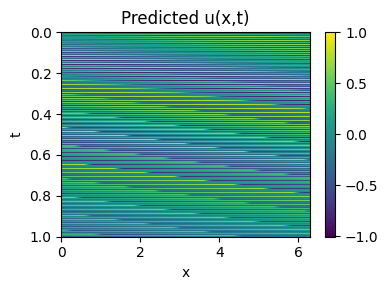

In [7]:
# Visualize PINNsformer
res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(256,100)

mat = scipy.io.loadmat('./burgers_shock.mat')
u = mat['usol'].reshape(256,100)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./convection_pinnsformer_pred.png')
plt.show()

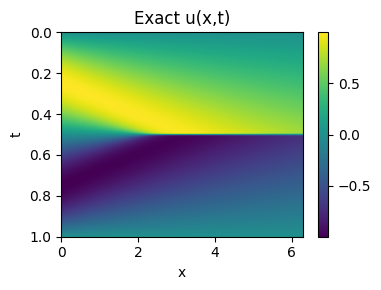

In [8]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_exact.png')
plt.show()

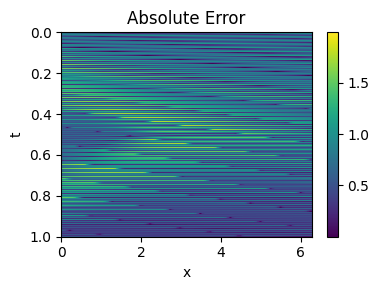

In [9]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_pinnsformer_error.png')
plt.show()